In [2]:
import pandas as pd
import numpy as np
import sklearn
import faiss

import spacy

# nlp = spacy.load('en_core_web_md')

from sentence_transformers import SentenceTransformer
import scipy.spatial

import pickle

In [3]:
def load_df(course_type):
    # course_type: credit course or online course
    # credit f21: take in free_text_f_21.csv
    # credit w22: take in free_text_w_22.csv
    # online course: take in online df
    
    if course_type == 'Fall 2021':
        df = pd.read_csv('C:/Users/hEBE2/assets/free_text_f_21.csv')
        corpus = df['text'].tolist()
        corpus_embeddings_file = 'C:/Users/hEBE2/assets/corpus_embeddings_f_21.pkl'
        embedder_file = 'C:/Users/hEBE2/assets/embedder_f_21.pkl'
        
    elif course_type == 'Winter 2022':
        df = pd.read_csv('C:/Users/hEBE2/assets/free_text_w_22.csv')
        corpus = df['text'].tolist()
        corpus_embeddings_file = 'C:/Users/hEBE2/assets/corpus_embeddings_w_22.pkl'
        embedder_file = 'C:/Users/hEBE2/assets/embedder_w_22.pkl'
        
    elif course_type == 'online':
        df = pd.read_csv('C:/Users/hEBE2/assets/original/2021-10-19-MichiganOnline-courses.csv')
        corpus = df['description'].tolist()
        corpus_embeddings_file = 'C:/Users/hEBE2/assets/corpus_embeddings_online.pkl'
        embedder_file = 'C:/Users/hEBE2/assets/embedder_online.pkl'
        
    return df, corpus_embeddings_file, embedder_file, corpus

In [4]:
df_OL, corpus_embeddings_file_OL, embedder_file_OL, corpus_OL = load_df('online')

In [5]:
def load_sentence_transformer(course_type):
    # course_type: credit course or online course
    # credit course: take in free_text_fw.csv
    # online course: take in online df
    
    df, corpus_embeddings_file, embedder_file, corpus = load_df(course_type)

    #Load sentences & embeddings from disc
    with open(corpus_embeddings_file, "rb") as fIn:
        stored_data = pickle.load(fIn)
        stored_corpus = stored_data['corpus']
        stored_embeddings = stored_data['embeddings']

    with open(embedder_file, "rb") as fIn:
        stored_embedder = pickle.load(fIn)
        
    return df, stored_data, stored_corpus, stored_embeddings, stored_embedder, corpus

In [7]:
df_OL, stored_data_OL, stored_corpus_OL, stored_embeddings_OL, stored_embedder_OL, corpus_OL = load_sentence_transformer('online')

In [13]:
df_OL.head()

,name,description,experience_type
0,Accounting for Decision Making,"Through this course, you will start by address...",course
1,Achieving Health Equity in Healthcare,The third and the last course of the Addressin...,course
2,"Act on Climate: Steps to Individual, Community...",Are you concerned about climate change? Would ...,course
3,Additive Manufacturing,"This course, Additive Manufacturing, is the th...",course
4,Advanced Concepts in Time Value of Money (TVM),This course builds upon the fundamental concep...,course


In [14]:
def recommender(course_type, queries, k):
    # query free text input from user about his interest
    # we want to see k nearest neighbors of query
    
    df, stored_data, stored_corpus, stored_embeddings, stored_embedder, corpus = load_sentence_transformer(course_type)

    d= 768
    index = faiss.IndexFlatL2(d)
    index.add(np.stack(stored_embeddings, axis=0))   

    query_embeddings = stored_embedder.encode(queries)
    D, I = index.search(query_embeddings, k)     # actual search

    if course_type == 'Fall 2021' or course_type == 'Winter 2022':
        df_1 = df[['course', 'Course Title','description']]
    
    else :
        df_1 = df[['name','description']]

    res = [df_1.iloc[I[i]] for i in range(len(queries))]

    l_dis = []
    for query, query_embedding in zip(queries, query_embeddings):
        distances, indices = index.search(np.asarray(query_embedding).reshape(1,768),k)        
        l_dis.append([distances[0,idx] for idx in range(0,k)])

    return(res, l_dis)

    '''
    for query, query_embedding in zip(queries, query_embeddings):
        distances, indices = index.search(np.asarray(query_embedding).reshape(1,768),k)
        print("\n======================\n")
        print("Query:", query)
        print("\nTop 5 most similar sentences in corpus:")
        for idx in range(0,k):
            print(corpus[indices[0,idx]], "(Distance: %.4f)" % distances[0,idx])
    '''

In [9]:
query_1 = input("Enter your interest 1, the more precise your text is, the more specific the recommandation will be: ")
query_2 = input("Enter your interest 2, the more precise your text is, the more specific the recommandation will be: ")
query_3 = input("Enter your interest 3, the more precise your text is, the more specific the recommandation will be: ")
query_4 = input("Enter your interest 4, the more precise your text is, the more specific the recommandation will be: ")
query_5 = input("Enter your interest 5, the more precise your text is, the more specific the recommandation will be: ")



In [10]:
print(query_1)
print(query_2)
print(query_3)
print(query_4)
print(query_5)

I like computer science as well as NLP
I like American history after the world war two
I am interested in maths and statistics.
I'm interested in popular culture especially Asian pop music.
I love art and history, especially African history


In [11]:
queries =[query_1, query_2, query_3, query_4,query_5]
print(queries)

['I like computer science as well as NLP', 'I like American history after the world war two', 'I am interested in maths and statistics.', "I'm interested in popular culture especially Asian pop music.", 'I love art and history, especially African history']


In [78]:
#recommender('Fall 2021', queries, 10)

In [16]:
# list of dfs 
dfs = recommender('online', queries, 20)[0]

# list of distance 
dis = recommender('online', queries, 20)[1]

In [19]:
import matplotlib.pyplot as plt
def vis(course_type, df, dis, title):
    fig, ax = plt.subplots()

    ax.set_xticks(range(len(dis)))
    
    if course_type == 'Fall 2021' or course_type == 'Winter 2022':
        ax.set_xticklabels(list(df['Course Title']), minor=False, rotation=90)
    else:
        ax.set_xticklabels(list(df['name']), minor=False, rotation=90)

    ax.plot(dis, linewidth=2.0)
    plt.title('Distance to'+' '+ "'"+ title +"'")

    plt.show()

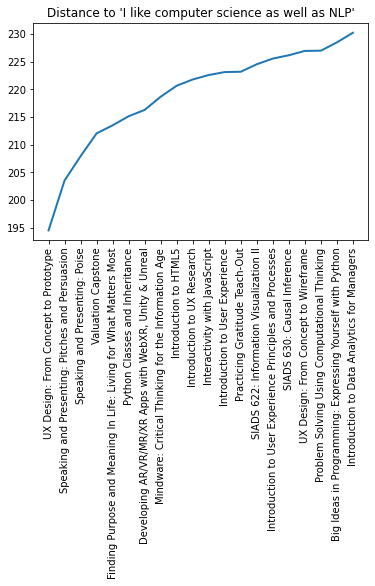

In [20]:
#vis("online", dfs[0], dis[0], queries[0])

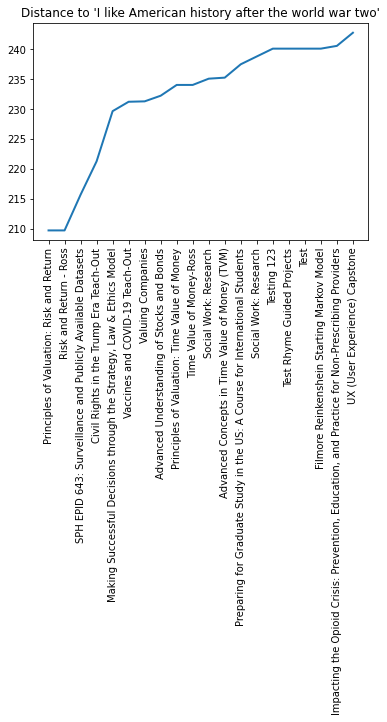

In [22]:
#vis("online", dfs[1], dis[1], queries[1])

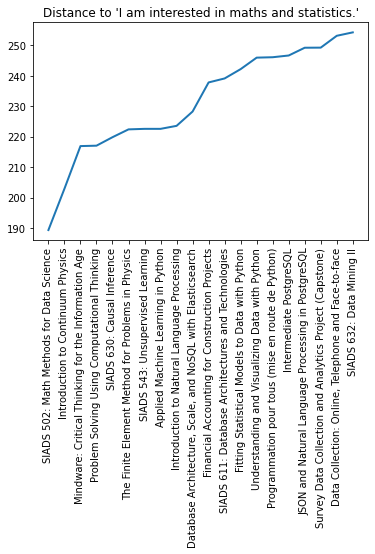

In [24]:
#vis("online",dfs[2], dis[2], queries[2])

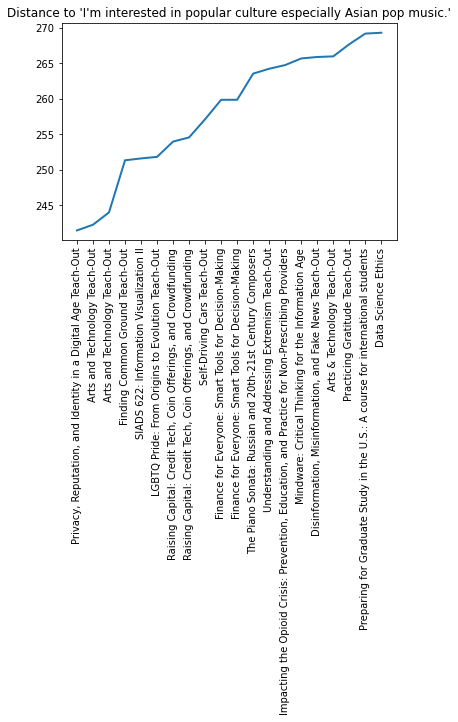

In [25]:
#vis("online", dfs[3], dis[3], queries[3])

In [28]:
#dfs_f21 = recommender('Fall 2021', queries, 20)[0]
#dis_f21 = recommender('Fall 2021', queries, 20)[1]


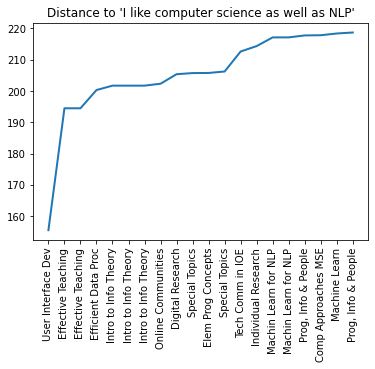

In [29]:
#vis("Fall 2021", dfs_f21[0], dis_f21[0], queries[0])

In [30]:
#dfs_w22 = recommender('Winter 2022', queries, 20)[0]
#dis_w22 = recommender('Winter 2022', queries, 20)[1]


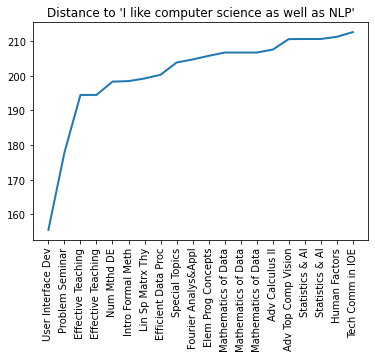

In [31]:
#vis("Winter 2022", dfs_w22[0], dis_w22[0], queries[0])